# Load libraries

In [296]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Read Data

In [297]:
# Data file
data = 'mf_firms.out'

# Data types
col_dtypes = {
    'gvkey': int,
    'year': int,
    'Y': float,
    'K': float,
    'L': float,
    'M': float,
    'VA': float,
    'i': float,
    'naics_4digit': int
}

# read data
df = pd.read_csv(data,
                 dtype=col_dtypes,
                 na_values='',
                 engine='c',
                 sep='\t',
                 encoding='utf-8')

# drop observations with negative VA
df = df[df.VA > 0]

# create variables
df['constant'] = 1
df['logY'] = np.log(df.Y)
df['logK'] = np.log(df.K)
df['logL'] = np.log(df.L)
df['logM'] = np.log(df.M)
df['logVA'] = np.log(df.VA)
df['logK_sq'] = df.logK ** 2
df['i_sq'] = df.i ** 2
df['logK_i'] = df.logK * df.i

# Q1

In [298]:
# Manufacturing firms
df = df[(df.naics_4digit // 100).isin([31, 32, 33])]
print(f"Number of firm-year observations: {len(df)}")
print(f"Number of distinct firms: {df.gvkey.nunique()}")

Number of firm-year observations: 24831
Number of distinct firms: 3288


In [299]:
# 2014 observations
df_2014 = df[df.year == 2014]
print(f"Aggregate total sales: {df_2014.Y.sum()}")
print(f"Aggregate number of workers hired: {df_2014.L.sum()}")

Aggregate total sales: 4591260.23520025
Aggregate number of workers hired: 10528.132


In [300]:
# average, sd and by percentile
df_2014[['Y', 'K', 'L', 'M', 'i']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,Y,K,L,M,i
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000
mean,4073.877760,2736.595859,9.341732,2842.036439,217.976530
std,15151.657828,19489.976884,24.056311,11862.933373,1482.425161
min,1.173315,0.054646,0.013000,0.076002,0.000000
5%,16.224744,4.305669,0.060000,10.153850,0.155999
25%,136.168214,45.435418,0.398000,81.868774,3.024911
50%,596.495205,235.887544,1.896000,372.430442,19.703879
75%,2381.245913,1209.219040,7.350000,1475.996664,87.314641
95%,15969.619109,8827.353219,46.803000,9469.033958,625.645970
max,259274.554682,525470.728374,302.000000,219383.525866,32894.516806


## Summarize Dataset
The dataset is panel data consisted of 29,836 firm-year observations. Years range from 1998 to 2014 (17 years), and there are 3,897 distinct firms. Firms are categorized into 83 4-digit NAICS codes.

# Q2

In [301]:
# OLS
reg = smf.ols('logY ~ logK + logL + logM', data=df_2014).fit(cov_type='HC3')
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logY   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.630e+04
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:57:04   Log-Likelihood:                 113.41
No. Observations:                1127   AIC:                            -218.8
Df Residuals:                    1123   BIC:                            -198.7
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8698      0.094     19.890      0.000       1.686       2.054
logK           0.0412      0.009      4.686      0.000       0.024       0.058
logL           0.2772      0.017     16.521      0.000       0.244       0.310
logM           0.6956      0.020     34.624      0.000       0.656       0.735
==============================================================================
Omnibus:                      575.422   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5164.627
Skew:                           2.174   Prob(JB):                         0.00
Kurtosis:                      12.543   Cond. No.                         55.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

All the coefficients are significant at the 1 percent level. Since the dependent variable and indepedent variables are log, the coefficients are interpreted as elasticities. Output elasticity of capital is 0.0412, of labor is 0.2772, and of materials is 0.6956.

In [302]:
# test constant returns to scale
reg.t_test('logK + logL + logM = 1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0140      0.004      3.521      0.000       1.006       1.022

Since the p-value is 0.000, the null hypothesis of constant returns to scale is rejected.

It is not likely that the OLS estimates are consistent estimates for the underlying output elasticities. Output is not solely determined by capital, labor, and materials, so it is very likely that the estimates suffer from omitted variable bias. For example, productivity greatly varies both across and within industry sectors, but this regression does not take it into account.

In [303]:
# OLS with sector dummy variables
reg2 = smf.ols('logY ~ logK + logL + logM + C(naics_4digit)', data=df_2014).fit(cov_type='HC3')
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logY   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1943.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:57:05   Log-Likelihood:                 201.33
No. Observations:                1127   AIC:                            -238.7
Df Residuals:                    1045   BIC:                             173.6
Df Model:                          81                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.8737      2.802      0.669      0.504      -3.618       7.366
C(naics_4digit)[T.3112]     0.1131      2.801      0.040      0.968      -5.376       5.602
C(naics_4digit)[T.3113]     0.0655      2.800      0.023      0.981      -5.423       5.554
C(naics_4digit)[T.3114]     0.1091      2.800      0.039      0.969      -5.379       5.598
C(naics_4digit)[T.3115]     0.2419      2.803      0.086      0.931      -5.252       5.736
C(naics_4digit)[T.3116]    -0.0032      2.800     -0.001      0.999      -5.492       5.485
C(naics_4digit)[T.3118]    -0.0222      2.800     -0.008      0.994      -5.510       5.466
C(naics_4digit)[T.3119]     0.1180      2.801      0.042      0.966      -5.372       5.608
C(naics_4digit)[T.3121]     0.1378      2.800      0.049      0.961      -5.351       5.626
C(naics_4digit)[T.3122]     0.5049      2.801      0.180      0.857      -4.986       5.996
C(naics_4digit)[T.3131]    -0.0750     49.679     -0.002      0.999     -97.444      97.294
C(naics_4digit)[T.3132]     0.0896      2.801      0.032      0.974      -5.400       5.579
C(naics_4digit)[T.3141]    -0.0705      2.800     -0.025      0.980      -5.559       5.418
C(naics_4digit)[T.3151]     0.2754      2.860      0.096      0.923      -5.330       5.881
C(naics_4digit)[T.3152]     0.0575      2.800      0.021      0.984      -5.431       5.546
C(naics_4digit)[T.3159]     0.0033      6.751      0.000      1.000     -13.228      13.235
C(naics_4digit)[T.3162]     0.0413      2.800      0.015      0.988      -5.447       5.530
C(naics_4digit)[T.3169]     0.2333      2.802      0.083      0.934      -5.258       5.724
C(naics_4digit)[T.3211]     0.2349     62.063      0.004      0.997    -121.407     121.877
C(naics_4digit)[T.3212]     0.0024      2.801      0.001      0.999      -5.488       5.492
C(naics_4digit)[T.3219]    -0.0151      2.800     -0.005      0.996      -5.503       5.473
C(naics_4digit)[T.3221]     0.0683      2.800      0.024      0.981      -5.420       5.556
C(naics_4digit)[T.3222]     0.0539      2.800      0.019      0.985      -5.435       5.543
C(naics_4digit)[T.3231]     0.1044      2.800      0.037      0.970      -5.384       5.593
C(naics_4digit)[T.3241]     0.3702      2.801      0.132      0.895      -5.120       5.861
C(naics_4digit)[T.3251]     0.2316      2.800      0.083      0.934      -5.257       5.720
C(naics_4digit)[T.3252]     0.1024      2.800      0.037      0.971      -5.386       5.591
C(naics_4digit)[T.3253]     0.2874      2.801      0.103      0.918      -5.203       5.778
C(naics_4digit)[T.3254]     0.2437      2.800      0.087      0.931      -5.245       5.732
C(naics_4digit)[T.3255]     0.0202      2.801      0.007      0.994      -5.469       5.509
C(naics_4digit)[T.3256]     0.1028      2.800  

The coefficients of capital, labor, and meterials are all significant at the 1 percent level. Output elasticity is now 0.0350 (capital), 0.3098 (labor), and 0.6760 (materials).

In [304]:
# test constant returns to scale
reg2.t_test('logK + logL + logM = 1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0207      0.004      4.955      0.000       1.013       1.029

Since the p-value is 0.000, the null hypothesis of constant returns to scale is rejected.

Although dummy variables for sector were introduced, productivity between firms within sector is still not being taken into account. Therefore, it is likely that the estimates are not consistent estimates for the underlying output elasticities.

# Q3

In [305]:
# 2013 and 2014 data
df_1314 = df[df.year.isin([2013, 2014])]

# unique gvkey in 2013 and 2014 data
gvkey_1314 = pd.Series(df_1314.gvkey.unique())

# gvkey that has both 2013 and 2014 observations
gvkey_complete_1314 = df_1314.groupby('gvkey')\
                                     .size()\
                                     .reset_index()\
                                     .rename(columns={0: 'size'})\
                                     .query('size == 2')\
                                     .gvkey

# restrict our dataset to those with complete data
df_1314 = df_1314[df_1314.gvkey.isin(gvkey_complete_1314)]

print(f"Number of dropped firms: {len(gvkey_1314[np.logical_not(gvkey_1314.isin(gvkey_complete_1314))])}")

Number of dropped firms: 186


In [306]:
# transform into first difference
df_1314[['dlogY', 'dlogK', 'dlogL', 'dlogM']] = df_1314\
    .sort_values(by='year')\
    .groupby(['gvkey'])[['logY', 'logK', 'logL', 'logM']]\
    .diff(1)

In [307]:
# OLS
reg = smf.ols('dlogY ~ dlogK + dlogL + dlogM', data=df_1314).fit(cov_type='HC3')
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dlogY   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     288.3
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          3.06e-136
Time:                        16:57:05   Log-Likelihood:                 968.11
No. Observations:                1046   AIC:                            -1928.
Df Residuals:                    1042   BIC:                            -1908.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0142      0.004      3.656      0.000       0.007       0.022
dlogK         -0.0457      0.027     -1.686      0.092      -0.099       0.007
dlogL          0.3803      0.038      9.967      0.000       0.306       0.455
dlogM          0.5710      0.061      9.288      0.000       0.451       0.692
==============================================================================
Omnibus:                      472.832   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25866.816
Skew:                           1.277   Prob(JB):                         0.00
Kurtosis:                      27.228   Cond. No.                         5.66
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

The coefficient of *dlogK* is not significant at the 5 percent level, while *dlogL* and *dlogM* are significant at the 1 percent level. Output elasticity of labor is 0.3803, and of materials is 0.5710.

In [308]:
reg.t_test('dlogK + dlogL + dlogM = 1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9056      0.043     -2.203      0.028       0.822       0.990

Since the p-value is 0.028, the null hypothesis of constant returns to scale is rejected.

First-difference approach captures time-invariable effects, which were not captured in the cross-sectional one based on the 2014 data alone. Therefore, if there does not exist any time-variable effect, these estimates will be consistent. However, it is likely to be the case. Firms keep making technological innovation, so productivity is likely to evolve over time, which then is not captured in this regression.

In [309]:
# OLS with dummy variables
reg2 = smf.ols('dlogY ~ dlogK + dlogL + dlogM + C(naics_4digit)', data=df_1314).fit(cov_type='HC3')
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dlogY   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     25.59
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          7.33e-188
Time:                        16:57:06   Log-Likelihood:                 1013.3
No. Observations:                1046   AIC:                            -1863.
Df Residuals:                     964   BIC:                            -1456.
Df Model:                          81                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0168      0.825      0.020      0.984      -1.600       1.633
C(naics_4digit)[T.3112]    -0.0893      0.825     -0.108      0.914      -1.706       1.528
C(naics_4digit)[T.3113]    -0.0716      0.826     -0.087      0.931      -1.690       1.547
C(naics_4digit)[T.3114]     0.0092      0.825      0.011      0.991      -1.607       1.626
C(naics_4digit)[T.3115]    -0.0383      0.830     -0.046      0.963      -1.666       1.589
C(naics_4digit)[T.3116]     0.0110      0.825      0.013      0.989      -1.606       1.628
C(naics_4digit)[T.3118]    -0.0153      0.825     -0.019      0.985      -1.632       1.601
C(naics_4digit)[T.3119]    -0.0919      0.829     -0.111      0.912      -1.717       1.534
C(naics_4digit)[T.3121]    -0.0208      0.825     -0.025      0.980      -1.638       1.596
C(naics_4digit)[T.3122]    -0.0120      0.827     -0.015      0.988      -1.632       1.608
C(naics_4digit)[T.3131]    -0.0230      0.963     -0.024      0.981      -1.911       1.865
C(naics_4digit)[T.3132]    -0.0110      0.825     -0.013      0.989      -1.628       1.606
C(naics_4digit)[T.3141]    -0.0075      0.825     -0.009      0.993      -1.625       1.610
C(naics_4digit)[T.3151]     0.0493      0.846      0.058      0.954      -1.608       1.707
C(naics_4digit)[T.3152]    -0.0211      0.825     -0.026      0.980      -1.638       1.595
C(naics_4digit)[T.3159]    -0.0365      0.825     -0.044      0.965      -1.653       1.580
C(naics_4digit)[T.3162]    -0.0148      0.825     -0.018      0.986      -1.632       1.602
C(naics_4digit)[T.3169]    -0.0270      0.825     -0.033      0.974      -1.644       1.590
C(naics_4digit)[T.3211]     0.0045      0.894      0.005      0.996      -1.748       1.757
C(naics_4digit)[T.3212]    -0.0243      0.827     -0.029      0.977      -1.644       1.596
C(naics_4digit)[T.3219]    -0.0140      0.825     -0.017      0.987      -1.630       1.603
C(naics_4digit)[T.3221]     0.0091      0.825      0.011      0.991      -1.608       1.626
C(naics_4digit)[T.3222]     0.0064      0.825      0.008      0.994      -1.610       1.623
C(naics_4digit)[T.3231]    -0.0018      0.825     -0.002      0.998      -1.619       1.615
C(naics_4digit)[T.3241]     0.0334      0.825      0.040      0.968      -1.584       1.651
C(naics_4digit)[T.3251]     0.0130      0.825      0.016      0.987      -1.604       1.630
C(naics_4digit)[T.3252]    -0.0281      0.825     -0.034      0.973      -1.645       1.589
C(naics_4digit)[T.3253]    -0.0797      0.825     -0.097      0.923      -1.697       1.537
C(naics_4digit)[T.3254]     0.0423      0.825      0.051      0.959      -1.575       1.659
C(naics_4digit)[T.3255]    -0.0501      0.826     -0.061      0.952      -1.669       1.569
C(naics_4digit)[T.3256]    -0.0194      0.825  

The coefficient of *dlogK* is not significant at the 5 percent level, while the coefficients of *dlogL* and *dlogM* are significant at the 1 percent level. Output elasticities of labor and materials are 0.3772 and 0.5699, respectively.

In [310]:
reg2.t_test('dlogK + dlogL + dlogM = 1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8977      0.041     -2.493      0.013       0.817       0.978

Since the p-value is 0.013, the null hypothesis of constant returns to scale is rejected.

Compared to the previous regression, this regression captures sector fixed effects. However, it still suffers from the same problem: it fails to capture time-variable effects, such as productivity.

# Q4

## Conditions for a consistent estimate of $\beta_0$
We need two key assumptions for $b_0$ to coincide with $\beta_0$.

A1. Redundancy: $E^*[\ln {VA}_t|\ln L_t, A_t] = E^*[\ln {VA}_t|\ln L_t, \ln A_t, W_t]$

A2. Conditional Uncorrelatedness: $E^*[\ln A_t|\ln L_t, W_t] = E^*[\ln A_t|W_t]$

Then, when $E^*[\ln {VA}_t|\ln K_t, \ln L_t, \ln A_t] = \alpha_0 \ln K_t + \beta_0 \ln L_t + \ln A_t$,

$$
\begin{align}
E^*[\ln {VA}_t|\ln L_t, W_t] & = E^*[E^*[\ln {VA}_t|\ln L_t, \ln A_t, W_t] |\ln L_t, W_t] \\
& = E^*[\alpha_0 \ln K_t + \beta_0 \ln L_t + \ln A_t + E^*[u | \ln L_t, \ln A_t, W_t]|\ln L_t, W_t] \\
& = E^*[\alpha_0 \ln K_t + \beta_0 \ln L_t + \ln A_t|\ln L_t, W_t] (\because \text{A1})\\
& = \alpha_0 \ln K_t + \beta_0 \ln L_t + E^*[\ln A_t |\ln L_t, W_t] \\
& = \alpha_0 \ln K_t + \beta_0 \ln L_t + E^*[\ln A_t | W_t] (\because \text{A2})\\
\end{align}
$$

Therefore, $b_0$ coincides with $\beta_0$.

This model also assumes that labor is freely adjustable at any time, but capital can be adjusted only slowly. 

## TFP
$\ln A_t$ evolves over time through an expected component $E[\ln A_t | I_{t-1}]$ and an unforecastable innovation $V_t$. The expected component is assumed to be a Markov process with a log-linear form.

## Proof of the Equation
By assuming a functional form of $\ln A_t$ as $\sum_{j = 1}^6 p_{tj} W_{tj}$, we have $E^*[\ln A_t | W_t] = \ln A_t$. Then,
$$
\begin{align}
E^*[\ln {VA}_t | \ln L_t, W_t]
& = \alpha_0 \ln K_t + \beta_0 \ln L_t + E^*[\ln A_t | W_t] \\
& = \beta_0 \ln L_t + \ln A_t + \alpha_0 \ln K_t \\
& = b_0 \ln L_t + \sum_{j = 1}^6 \pi_{tj} W_{tj} \\
\therefore \ln A_t & = \sum_{j = 1}^6 \pi_{tj} W_{tj} - \alpha_0 \ln K_t \\
& = \varphi_t(K_t, i_t) - \alpha_0 \ln K_t
\end{align}
$$

$$
\begin{align}
\ln {VA}_t 
& = \alpha_0 \ln K_t + \beta_0 \ln L_t + \ln A_t \\
& = \alpha_0 \ln K_t + \beta_0 \ln L_t + \lambda_0 + \rho \ln A_{t-1} + V_t \\
\ln {VA}_t - \beta_0 \ln L_t & = \lambda_0 + \alpha_0 \ln K_t + \rho \ln A_{t-1} + V_t \\
& = \lambda_0 + \alpha_0 \ln K_t + \rho (\varphi_{t-1}(K_{t-1}, i_{t-1}) - \alpha_0 \ln K_{t-1}) + V_t
\end{align}
$$

## part 1

In [311]:
# 2013 data
df_2013 = df[(df.year == 2013) & (df.gvkey.isin(gvkey_complete_1314))]

# Regression
reg = smf.ols('logVA ~ logK + i + logK_sq + i_sq + logK_i + logL', data=df_2013).fit(cov_type='HC3')
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  logVA   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     2042.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:57:06   Log-Likelihood:                -961.94
No. Observations:                1046   AIC:                             1938.
Df Residuals:                    1039   BIC:                             1973.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4470      0.156     22.129      0.000       3.142       3.752
logK           0.2315      0.047      4.882      0.000       0.139       0.324
i              0.0005      0.002      0.339      0.734      -0.002       0.003
logK_sq       -0.0036      0.004     -0.981      0.327      -0.011       0.004
i_sq        1.033e-09   1.35e-08      0.076      0.939   -2.55e-08    2.76e-08
logK_i     -4.056e-05      0.000     -0.269      0.788      -0.000       0.000
logL           0.8599      0.029     29.999      0.000       0.804       0.916
==============================================================================
Omnibus:                      703.103   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32163.325
Skew:                          -2.480   Prob(JB):                         0.00
Kurtosis:                      29.709   Cond. No.                     3.09e+08
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 3.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The coefficient of *logL* is significant at the 1 percent level. Output elasticity of labor is estimated to be 0.8599.

## part 2

In [312]:
df_2013['phi'] = np.matmul(df_2013[['constant', 'logK', 'i', 'logK_sq', 'i_sq', 'logK_i']], 
                           np.transpose(reg.params[:-1]))
b_hat = reg.params[-1]

C:\Users\mshin\Anaconda3\envs\econ142\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## part 3

In [313]:
df_2014 = df[(df.year == 2014) & (df.gvkey.isin(gvkey_complete_1314))].merge(df_2013[['gvkey', 'phi', 'logK']],
                                                                             on='gvkey', how='left', 
                                                                             suffixes=('_2014', '_2013'))
reg2 = smf.ols('logVA - b_hat * logL ~ logK_2014 + phi + logK_2013', 
               data=df_2014).fit(cov_type='HC3')
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  logVA   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1336.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:57:06   Log-Likelihood:                -1372.0
No. Observations:                1046   AIC:                             2752.
Df Residuals:                    1042   BIC:                             2772.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8300      3.451     -0.530      0.596      -8.594       4.934
logK_2014      1.0250      0.194      5.293      0.000       0.645       1.405
phi            0.6547      0.991      0.661      0.509      -1.287       2.597
logK_2013     -0.2993      0.257     -1.167      0.243      -0.802       0.204
==============================================================================
Omnibus:                       68.234   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.195
Skew:                          -0.478   Prob(JB):                     5.87e-26
Kurtosis:                       4.324   Cond. No.                         641.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

- $\alpha_0$: Coefficient of *logK_2014*, 1.0250
- $\beta_0$: Coefficient of *logL* from earlier, 0.8599
- $\rho_0$: Coefficient of *phi*, 0.6547. In theory, the coefficient of *logK_2013* should be equal to $-\alpha_0 \rho_0 = 0.6711$, but here it is estimated to be $-0.2993$ instead.

# Q5

In [314]:
df_2014['A'] = df_2014['VA'] / df_2014['K'] ** reg2.params[1] / df_2014['L'] ** b_hat

df_2014.A.describe()

count    1046.000000
mean        4.244074
std        36.246916
min         0.001329
25%         0.088458
50%         0.323611
75%         1.272761
max      1018.733526
Name: A, dtype: float64

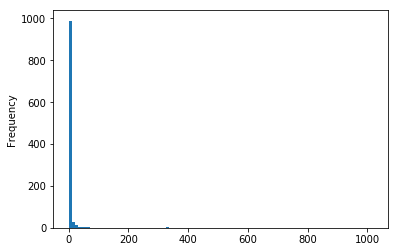

In [315]:
plt.figure()
df_2014.A.plot.hist(bins=100)

Since we assumed $VA = A K^\alpha L^\beta$, this ratio can be interpreted as productivity $A$.

# Q6

## Proof
Since $S_t = Y_t / E[Y_t]$, $E[S_t] = E[Y_t] / E[Y_t] = 1$.

$Cov(S_t, A_t) = E[S_t A_t] - E[S_t] E[A_t] \implies E[S_t A_t] = E[S_t] E[A_t] + Cov(S_t, A_t)$

Let $E^*[S_t | A_t] = \alpha_{A_t, S_t} + \beta_{A_t, S_t} A_t$. Then, $S_t = \alpha_{A_t, S_t} + \beta_{A_t, S_t} A_t + u_t$.

But, 
$$
\begin{align}
Cov(S_t, A_t) & = Cov(\alpha_{A_t, S_t} + \beta_{A_t, S_t} A_t + u_t, A_t) \\
& = \beta_{A_t, S_t} Cov(A_t, A_t) + Cov(u_t, A_t) \\
& = \beta_{A_t, S_t} Var(A_t) \\
\therefore E[S_t A_t] & = E[S_t] E[A_t] + Cov(S_t, A_t) \\
& = E[A_t] + \beta_{A_t, S_t} Var(A_t)
\end{align}
$$

## Interpretation
$S_t A_t$ is productivity weighted by output relative to average output. Therefore, the decomposition can be interpreted as the expectation of productivity weighted by relative output is explained by (a) the expectation of productivity, and (b) variability of productivity which affects $S_t A_t$ through $S_t$, denoted by $\beta_{A_t, S_t}$.

In [316]:
df_2014['S'] = df_2014.VA / df_2014.VA.mean()
df_2014['S_A'] = df_2014.S * df_2014.A

print(f"E[A_t]: {df_2014.A.mean()}")
print(f"Var[A_t]: {df_2014.A.var()}")
print(f"beta: {(df_2014.S_A.mean() - df_2014.A.mean()) / df_2014.A.var()}")
print(f"beta * Var[A_t] = {df_2014.S_A.mean() - df_2014.A.mean()}")

E[A_t]: 4.244074445949466
Var[A_t]: 1313.8389503899182
beta: -0.0031279587629540425
beta * Var[A_t] = -4.109634057982486


# Q7
The given dataset is panel data with firm-by-year observations. To estimate output elasticities, we took 3 different approaches: OLS, first-difference, and proxy variable regression. But, OLS and first-difference estimates are not likely to be consistent for the underlying elasticities, since time-variable effects, such as productivity, are not captured in the regression.

In contrast, proxy variable regression takes account of productivity $A_t$ by assuming a functional form with $W_t$. Under a set of assumptions, including redundancy and conditional uncorrelatedness, the estimates are consistent for the underlying elasticities. We used the 2013 data to estimate $\beta_0$ and $\varphi$, with which we estimated other elasticities with the 2014 data.

With the estimates, we can now estimate productivity $A_t$, which is obtained as the ratio $\frac{VA}{K^\alpha L^\beta}$. With the estimate, we also performed decomposition of expected productivity weighted by relative output into expected productivity and variability of productivity.